<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Modeling Walkthrough

_Authors: Riley Dallas (AUS)_

---

### Learning Objectives
*After this lesson, you will be able to:*

- Gather, clean, explore and model a dataset from scratch. 
    - In other words, familiarize with the end-to-end workflow of getting from data to insights.
- Split data into testing and training sets using both train/test split and cross-validation and apply both techniques to score a model.
- Evaluate several models. 
    - If you recall, up until now, we were only evaluating one model at a time. As a Data Scientist, you're almost always evaluating multiple models and choosing the best one.

In a nut shell, this lesson will recap a lot of our previous separate lessons for revision of concepts and application under one roof. 

## Importing libaries
---

We'll need the following libraries for today's lesson:

1. `pandas`
2. `numpy`
3. `seaborn`
4. `matplotlib.pyplot`
4. `train_test_split` and `cross_val_score` from `sklearn`'s `model_selection` module
5. `LinearRegression`, `LassoCV` and `RidgeCV` from `sklearn`'s `linear_model` module
6. `StandardScaler` from `sklearn`'s `preprocessing` module
7. `r2_score` from `sklearn`'s `metrics` module 

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

## Loading the Data

---

Today's [dataset](http://www-bcf.usc.edu/~gareth/ISL/data.html) (`College.csv`) is from the [ISLR website](http://www-bcf.usc.edu/~gareth/ISL/). 

***<span style="color:blue">Task</span>***: Rename `Unnamed: 0` to `University`.

In [2]:
df = pd.read_csv('../datasets/College.csv')
df.rename(columns={'Unnamed: 0': 'University'}, inplace=True)
print(df.shape)
df.head()

(777, 19)


University Private  Apps  Accept  Enroll  Top10perc  \
0  Abilene Christian University     Yes  1660    1232     721         23   
1            Adelphi University     Yes  2186    1924     512         16   
2                Adrian College     Yes  1428    1097     336         22   
3           Agnes Scott College     Yes   417     349     137         60   
4     Alaska Pacific University     Yes   193     146      55         16   

   Top25perc  F.Undergrad  P.Undergrad  Outstate  Room.Board  Books  Personal  \
0         52         2885          537      7440        3300    450      2200   
1         29         2683         1227     12280        6450    750      1500   
2         50         1036           99     11250        3750    400      1165   
3         89          510           63     12960        5450    450       875   
4         44          249          869      7560        4120    800      1500   

  PhD  Terminal  S.F.Ratio  perc.alumni  Expend  Grad.Rate  
0  70        78       18.1           12    7041         60  
1  29        30       12.2           16   10527         56  
2  53        66       12.9           30    8735         54  
3  92        97        7.7           37   19016         59  
4  76        72       11.9            2   10922         15

## Data cleaning: Initial check
---

***<span style="color:blue">Task</span>***: Check the following:
1. Do we have any null values?
2. Are any numerical columns being read in as `object`?

In [3]:
# Check for nulls
df.isnull().sum()

University     0
Private        0
Apps           0
Accept         0
Enroll         0
Top10perc      0
Top25perc      0
F.Undergrad    0
P.Undergrad    0
Outstate       0
Room.Board     0
Books          0
Personal       0
PhD            0
Terminal       0
S.F.Ratio      0
perc.alumni    0
Expend         0
Grad.Rate      0
dtype: int64

In [4]:
# Check column data types
df.dtypes

University      object
Private         object
Apps             int64
Accept           int64
Enroll           int64
Top10perc        int64
Top25perc        int64
F.Undergrad      int64
P.Undergrad      int64
Outstate         int64
Room.Board       int64
Books            int64
Personal         int64
PhD             object
Terminal         int64
S.F.Ratio      float64
perc.alumni      int64
Expend           int64
Grad.Rate        int64
dtype: object

In [5]:
# df.info() answers both #1 and #2
# conclusion#1 : no nulls, num of non-nulls#777 matches df.shape rows
# conclusion#2 : of all the 'object' cols, 'PhD' is incorrect
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   University   777 non-null    object 
 1   Private      777 non-null    object 
 2   Apps         777 non-null    int64  
 3   Accept       777 non-null    int64  
 4   Enroll       777 non-null    int64  
 5   Top10perc    777 non-null    int64  
 6   Top25perc    777 non-null    int64  
 7   F.Undergrad  777 non-null    int64  
 8   P.Undergrad  777 non-null    int64  
 9   Outstate     777 non-null    int64  
 10  Room.Board   777 non-null    int64  
 11  Books        777 non-null    int64  
 12  Personal     777 non-null    int64  
 13  PhD          777 non-null    object 
 14  Terminal     777 non-null    int64  
 15  S.F.Ratio    777 non-null    float64
 16  perc.alumni  777 non-null    int64  
 17  Expend       777 non-null    int64  
 18  Grad.Rate    777 non-null    int64  
dtypes: float

In [6]:
# below syntax is an option to narrow on 'object' cols,
# without .columns, the output is a subset dataframe with only 'object' cols
df.select_dtypes(include=['object']).columns

# df.select_dtypes(include=['int64','float64']) will return a subset dataframe with only int/float cols

Index(['University', 'Private', 'PhD'], dtype='object')

## Data cleaning: Clean up `PhD` column
---

`PhD` is being read in as a `string` (or, `object`) because some of the cells contain non-numerical values. 

Let's replace any non-numerical values with `NaN`'s, and change the column datatype to float.

In [7]:
df['PhD'].unique() # notice the '?' which is corrupting this column from its data type being identified correctly

array(['70', '29', '53', '92', '76', '?', '90', '89', '79', '40', '82',
       '73', '60', '36', '78', '48', '62', '69', '83', '55', '88', '57',
       '93', '85', '65', '66', '81', '59', '58', '68', '98', '71', '74',
       '61', '35', '87', '80', '63', '75', '39', '99', '100', '95', '77',
       '72', '64', '10', '86', '22', '50', '41', '8', '67', '94', '56',
       '46', '54', '84', '97', '51', '42', '49', '52', '43', '37', '45',
       '47', '91', '31', '96', '34', '33', '44', '32', '14', '103', '26',
       '16'], dtype=object)

In [8]:
# let's write a list comprehension to replace the '?' with nan, leave numerical values intact
# After "else" is the output to be executed corresponding to "if" condition = false
# Before "if" is the output to be executed corresponding to "if" condition = true
df['PhD'] = [np.nan if phd=='?' else float(phd) for phd in df['PhD'].values]

In [9]:
# PhD is no longer recognized as a string
# the nan's in PhD (29), reduce the number of non-nulls for the col from 777
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   University   777 non-null    object 
 1   Private      777 non-null    object 
 2   Apps         777 non-null    int64  
 3   Accept       777 non-null    int64  
 4   Enroll       777 non-null    int64  
 5   Top10perc    777 non-null    int64  
 6   Top25perc    777 non-null    int64  
 7   F.Undergrad  777 non-null    int64  
 8   P.Undergrad  777 non-null    int64  
 9   Outstate     777 non-null    int64  
 10  Room.Board   777 non-null    int64  
 11  Books        777 non-null    int64  
 12  Personal     777 non-null    int64  
 13  PhD          748 non-null    float64
 14  Terminal     777 non-null    int64  
 15  S.F.Ratio    777 non-null    float64
 16  perc.alumni  777 non-null    int64  
 17  Expend       777 non-null    int64  
 18  Grad.Rate    777 non-null    int64  
dtypes: float

## Data cleaning: Drop `NaN`'s
---

If we can confirm that there are a small percentage of nulls, we can go ahead and drop them across the entire dataframe.

In [10]:
# to confirm that our %nulls are really small,
# especially, when there are nulls across different cols, 
# converting the result from df.isna().sum() to dataframe can help us to perform computations like %nulls
df.isna().sum()

University      0
Private         0
Apps            0
Accept          0
Enroll          0
Top10perc       0
Top25perc       0
F.Undergrad     0
P.Undergrad     0
Outstate        0
Room.Board      0
Books           0
Personal        0
PhD            29
Terminal        0
S.F.Ratio       0
perc.alumni     0
Expend          0
Grad.Rate       0
dtype: int64

In [11]:
pd.DataFrame(df.isna().sum()).reset_index() # w/o reset_index, df_cols become indices

index   0
0    University   0
1       Private   0
2          Apps   0
3        Accept   0
4        Enroll   0
5     Top10perc   0
6     Top25perc   0
7   F.Undergrad   0
8   P.Undergrad   0
9      Outstate   0
10   Room.Board   0
11        Books   0
12     Personal   0
13          PhD  29
14     Terminal   0
15    S.F.Ratio   0
16  perc.alumni   0
17       Expend   0
18    Grad.Rate   0

In [12]:
# getting %nulls for cols with missing values
missing_df = pd.DataFrame(df.isna().sum()).reset_index()
missing_df.columns = ['col', 'num_nulls'] # updating all col names in missing_df
missing_df['%nulls'] = missing_df['num_nulls']*100/len(df) #creating a new col for %nulls (num_nulls/df_len)
missing_df[missing_df['num_nulls']>0] # filter to only cols with any nulls

col  num_nulls    %nulls
13  PhD         29  3.732304

We've confirmed from above that the %nulls is ~4% only from one feature, 'PhD'.

***<span style="color:blue">Task</span>***: Drop na from the entire dataframe

In [13]:
df.dropna(inplace=True)
df.shape # results in df.shape = num of non-nulls from PhD col

(748, 19)

## Feature engineering: Binarize `'Private'` column
---

In the cells below, convert the `Private` column into numerical values.

In [14]:
df['Private']

0      Yes
1      Yes
2      Yes
3      Yes
4      Yes
      ... 
772     No
773    Yes
774    Yes
775    Yes
776    Yes
Name: Private, Length: 748, dtype: object

In [15]:
df['Private'] = df['Private'].map({'Yes': 1, 'No': 0}) # .map for Series transformation

# You could use an apply function too!
# df['Private'] = df['Private'].apply(lambda x: 1 if x=="Yes" else 0)

df['Private']

0      1
1      1
2      1
3      1
4      1
      ..
772    0
773    1
774    1
775    1
776    1
Name: Private, Length: 748, dtype: int64

## EDA: Plot a Heatmap of the Correlation Matrix
---

Heatmaps are an effective way to visually examine the correlational structure of your predictors. 

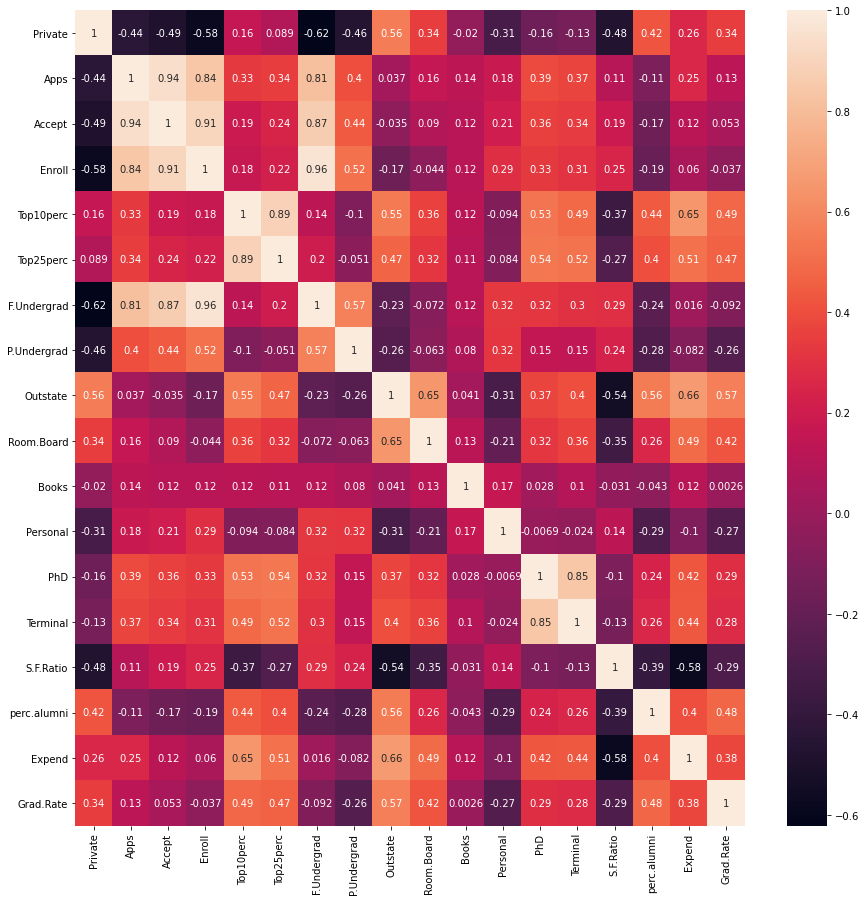

In [16]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True);

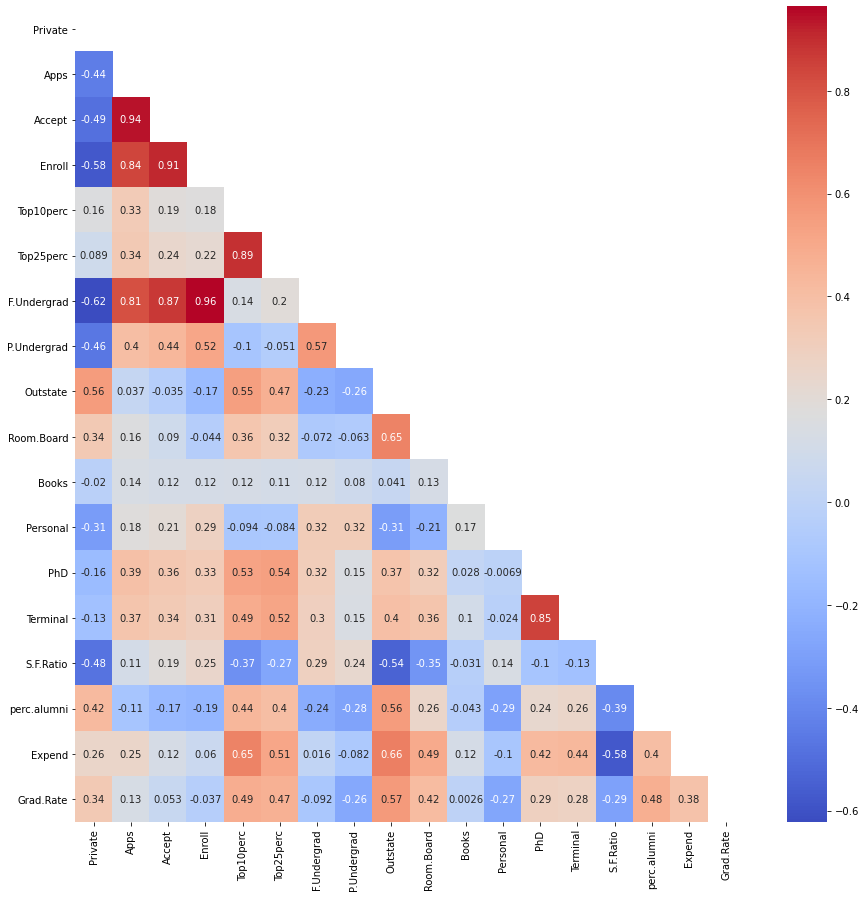

In [17]:
# applying masking techniques from past lessons to see only one half heatmap,
# below diagonal capturing a col's correlation against itself
plt.figure(figsize=(15,15))
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, annot = True, cmap='coolwarm'); # 'coolwarm' colormap is easier to read in my opinion

#### We can see quite a number of features are strongly correlated (>=0.5 corr coeff) to the response, `Apps` as well as to themselves

## EDA: Use seaborn's `.pairplot()` method to create scatterplots 
---
[seaborn documentation](https://seaborn.pydata.org/generated/seaborn.pairplot.html)

Let's create a pairplot to see how some of our stronger predictors correlate to our target (`Apps`). Instead of creating a pairplot of the entire DataFrame, we can use the `y_vars` and `x_vars` params to get a smaller subset.

In [18]:
df.corr().head()

Private      Apps    Accept    Enroll  Top10perc  Top25perc  \
Private    1.000000 -0.441434 -0.486012 -0.576422   0.160826   0.089417   
Apps      -0.441434  1.000000  0.943316  0.842801   0.330712   0.344498   
Accept    -0.486012  0.943316  1.000000  0.908498   0.187160   0.243253   
Enroll    -0.576422  0.842801  0.908498  1.000000   0.175119   0.221952   
Top10perc  0.160826  0.330712  0.187160  0.175119   1.000000   0.891526   

           F.Undergrad  P.Undergrad  Outstate  Room.Board     Books  Personal  \
Private      -0.621835    -0.463644  0.557764    0.344050 -0.020181 -0.312755   
Apps          0.811162     0.400406  0.036517    0.162503  0.138333  0.182639   
Accept        0.871578     0.442175 -0.034997    0.090486  0.119390  0.206501   
Enroll        0.964090     0.517240 -0.167285   -0.044212  0.117067  0.288144   
Top10perc     0.136884    -0.102003  0.547878    0.361531  0.121732 -0.093697   

                PhD  Terminal  S.F.Ratio  perc.alumni    Expend  Grad.Rate  
Private   -0.161132 -0.128911  -0.475460     0.420522  0.255115   0.343915  
Apps       0.389312  0.368173   0.109378    -0.105778  0.252854   0.129846  
Accept     0.356204  0.336895   0.187527    -0.170183  0.122433   0.052750  
Enroll     0.331744  0.306225   0.249070    -0.190804  0.060381  -0.037259  
Top10perc  0.528991  0.488337  -0.366350     0.438145  0.648298   0.485008

In [19]:
# we'll filter to only 'Apps' col as that is our response that we want to chk correlation vs other feature cols
# sort_values sorts smallest to largest by default
p_val = df.corr()['Apps'].sort_values(ascending=False)

# filtering to top correlated features with pearson coeff > 0.5
p_val_high = p_val[p_val>0.5]

p_val_high

Apps           1.000000
Accept         0.943316
Enroll         0.842801
F.Undergrad    0.811162
Name: Apps, dtype: float64

In [20]:
# To get only the index of the above series
p_val_high.index

Index(['Apps', 'Accept', 'Enroll', 'F.Undergrad'], dtype='object')

In [21]:
# To check if ANY item in the index list is in another list (response)
response = ['Apps'] # new list
p_val_high.index.isin(response)

array([ True, False, False, False])

In [22]:
# To invert the above boolean list
~p_val_high.index.isin(response)

array([False,  True,  True,  True])

In [23]:
# declaring our response col, so it can be filtered from p_val_high,
# to give us purely, correlated features to response
response = ['Apps'] 
top_corr_features = p_val_high[~p_val_high.index.isin(response)] # ~ is for NOT

print(top_corr_features.index)
top_corr_features

Index(['Accept', 'Enroll', 'F.Undergrad'], dtype='object')


Accept         0.943316
Enroll         0.842801
F.Undergrad    0.811162
Name: Apps, dtype: float64

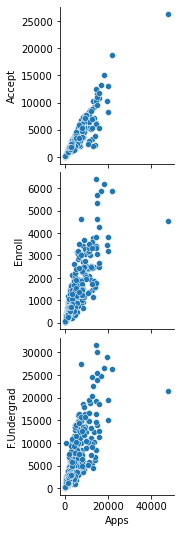

In [24]:
# plotting the sns.pairplot
# the distribution bars that appear usually when we do sns.pairplot don't show up here because,
# we are not plotting the same feature against itself. eg., 'Accept' vs 'Accept'
sns.pairplot(df, y_vars=top_corr_features.index, x_vars=['Apps']);

## EDA: Create histograms of all numerical columns
---
Based on histogram inspection, several features appear to be zero-inflated and not following normal distribution.

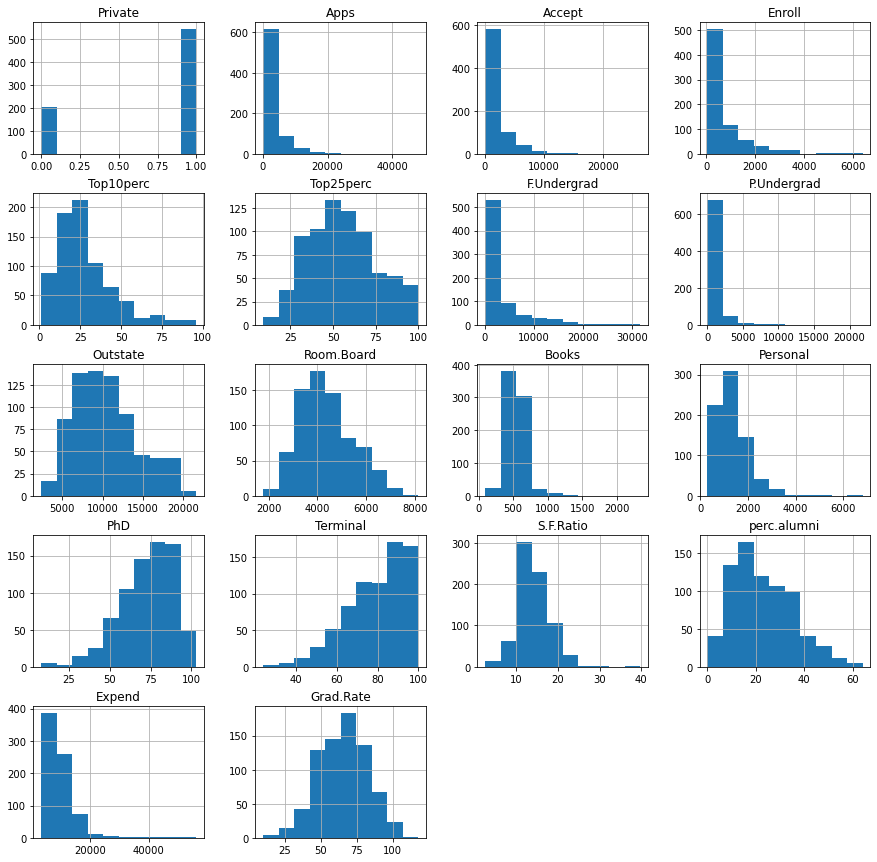

In [25]:
df.hist(figsize=(15, 15));

## EDA: Boxplots
---

Let's create two boxplots:
1. One for our target (`Apps`)
2. And one for our strongest predictor (`Accept`)

We can see that they have a lot of outliers.

Admittedly you can get the same observation by taking a closer look at the histograms itself. But Box plots are a conventient way to check for outliers

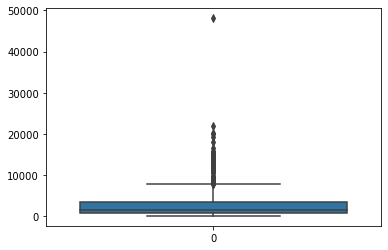

In [26]:
sns.boxplot(data=df['Apps']);

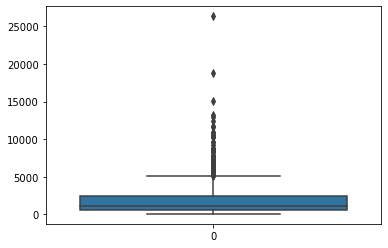

In [27]:
sns.boxplot(data=df['Accept']);

## Model Prep: Create our features matrix (`X`) and target vector (`y`)
---

Every **numerical** column (that is not our target) will be used as a feature.

The `Apps` column is our label: the number of applications received by that university.

In the cell below, create your `X` and `y` variables.

In [28]:
# we know from df.info() that this means, we will need to leave out 'University'
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748 entries, 0 to 776
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   University   748 non-null    object 
 1   Private      748 non-null    int64  
 2   Apps         748 non-null    int64  
 3   Accept       748 non-null    int64  
 4   Enroll       748 non-null    int64  
 5   Top10perc    748 non-null    int64  
 6   Top25perc    748 non-null    int64  
 7   F.Undergrad  748 non-null    int64  
 8   P.Undergrad  748 non-null    int64  
 9   Outstate     748 non-null    int64  
 10  Room.Board   748 non-null    int64  
 11  Books        748 non-null    int64  
 12  Personal     748 non-null    int64  
 13  PhD          748 non-null    float64
 14  Terminal     748 non-null    int64  
 15  S.F.Ratio    748 non-null    float64
 16  perc.alumni  748 non-null    int64  
 17  Expend       748 non-null    int64  
 18  Grad.Rate    748 non-null    int64  
dtypes: float

In [29]:
# just for clarity, the 'University' categorical col has 748 unique values of university names!!
# one-hot encoding these is going to make our dataset for modeling extremely noisy. so,
# we'll leave this col out. and focus on building a predictive model for the applications,
# that a university receives, based on other features
df['University'].nunique()

748

In [30]:
# alternative way for us to get a subset from df with only numeric columns
df._get_numeric_data()

Private   Apps  Accept  Enroll  Top10perc  Top25perc  F.Undergrad  \
0          1   1660    1232     721         23         52         2885   
1          1   2186    1924     512         16         29         2683   
2          1   1428    1097     336         22         50         1036   
3          1    417     349     137         60         89          510   
4          1    193     146      55         16         44          249   
..       ...    ...     ...     ...        ...        ...          ...   
772        0   2197    1515     543          4         26         3089   
773        1   1959    1805     695         24         47         2849   
774        1   2097    1915     695         34         61         2793   
775        1  10705    2453    1317         95         99         5217   
776        1   2989    1855     691         28         63         2988   

     P.Undergrad  Outstate  Room.Board  Books  Personal   PhD  Terminal  \
0            537      7440        3300    450      2200  70.0        78   
1           1227     12280        6450    750      1500  29.0        30   
2             99     11250        3750    400      1165  53.0        66   
3             63     12960        5450    450       875  92.0        97   
4            869      7560        4120    800      1500  76.0        72   
..           ...       ...         ...    ...       ...   ...       ...   
772         2029      6797        3900    500      1200  60.0        60   
773         1107     11520        4960    600      1250  73.0        75   
774          166      6900        4200    617       781  67.0        75   
775           83     19840        6510    630      2115  96.0        96   
776         1726      4990        3560    500      1250  75.0        75   

     S.F.Ratio  perc.alumni  Expend  Grad.Rate  
0         18.1           12    7041         60  
1         12.2           16   10527         56  
2         12.9           30    8735         54  
3          7.7           37   19016         59  
4         11.9            2   10922         15  
..         ...          ...     ...        ...  
772       21.0           14    4469         40  
773       13.3           31    9189         83  
774       14.4           20    8323         49  
775        5.8           49   40386         99  
776       18.1           28    4509         99  

[748 rows x 18 columns]

In [31]:
# get a list of all numeric columns from above
df._get_numeric_data().columns

Index(['Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'F.Undergrad', 'P.Undergrad', 'Outstate', 'Room.Board', 'Books',
       'Personal', 'PhD', 'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend',
       'Grad.Rate'],
      dtype='object')

In [32]:
# list comprehension to exclude the response col, 'Apps'
# notice that in a list comprehension syntax, IF "if" condition is used alone, WITHOUT "else",
# the "if" condition goes AFTER "for" statement in the list comprehension declaration
features = [col for col in df._get_numeric_data().columns if col != 'Apps']
features

['Private',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 'F.Undergrad',
 'P.Undergrad',
 'Outstate',
 'Room.Board',
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 'S.F.Ratio',
 'perc.alumni',
 'Expend',
 'Grad.Rate']

In [33]:
X = df[features]
y = df['Apps']

In [34]:
X.head() # feature matrix

Private  Accept  Enroll  Top10perc  Top25perc  F.Undergrad  P.Undergrad  \
0        1    1232     721         23         52         2885          537   
1        1    1924     512         16         29         2683         1227   
2        1    1097     336         22         50         1036           99   
3        1     349     137         60         89          510           63   
4        1     146      55         16         44          249          869   

   Outstate  Room.Board  Books  Personal   PhD  Terminal  S.F.Ratio  \
0      7440        3300    450      2200  70.0        78       18.1   
1     12280        6450    750      1500  29.0        30       12.2   
2     11250        3750    400      1165  53.0        66       12.9   
3     12960        5450    450       875  92.0        97        7.7   
4      7560        4120    800      1500  76.0        72       11.9   

   perc.alumni  Expend  Grad.Rate  
0           12    7041         60  
1           16   10527         56  
2           30    8735         54  
3           37   19016         59  
4            2   10922         15

In [35]:
y # response vector

0       1660
1       2186
2       1428
3        417
4        193
       ...  
772     2197
773     1959
774     2097
775    10705
776     2989
Name: Apps, Length: 748, dtype: int64

## Model Prep: Train/test split
---

We always want to have a **holdout** set to test our model, AFTER training. This holdout set is used to _simulate_ new future data outside of this dataset, to build a future-proof model that generalizes and performs well. 

***<span style="color:blue">Task</span>***: Use the `train_test_split` function to split our `X` and `y` variables into a training set and a holdout set.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Model Prep: Scaling
---

Since we're using `Lasso` and `Ridge`, we'll want to scale our features. 

If in doubt whether to scale your features or not, its safer to go ahead and scale.

***<span style="color:blue">Task</span>***: In the cell below, fit a `StandardScaler` to `X_train` and use it to transform both `X_train` and `X_test`.

In [37]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)# the same as doing ss.fit(X_train), then X_train=ss.transform(X_train)
X_test = ss.transform(X_test)

## Model Prep: Instantiate our models
---

We'll be evaluating `LinearRegression`, `LassoCV` and `RidgeCV`, and see which one yields the best model metric.

***<span style="color:blue">Task</span>***: Instantiate all three models.

In [38]:
lr = LinearRegression()

In [39]:
lasso = LassoCV(n_alphas=200)# n_alphas: Number of alphas to use for the regularization
# to pass alpha values instead, we had used the parameter, 'alphas'

In [40]:
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))# alphas takes an Array of alpha values for regularization

## Cross validation
---

***<span style="color:blue">Task</span>***: Use `cross_val_score` to evaluate all three models on the training dataset.

In [41]:
# cross_val_score: Evaluates a score by cross-validation. number of folds is given in cv (default=5)
lr_scores = cross_val_score(lr, X_train, y_train, cv=3)

print(lr_scores) # to show r^2 from each of the 3 fold validations
lr_scores.mean() # to average r^2 from across cv evaluations

[0.9172677  0.90275292 0.91402718]


0.911349266788128

In [42]:
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=3)
lasso_scores.mean()

0.9141628167115297

In [43]:
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=3)
ridge_scores.mean()

0.9109281882194096

## Model Fitting and Evaluation
---

`LassoCV` seems to be doing the best based on $R^2$ scoring confirmation from our training cross validation, so let's move forward with that model. 

***<span style="color:blue">Task</span>***: Let's fit the LassoCV model to the training data, evaluate the training and test scores and make predictions below.

In [44]:
lasso.fit(X_train, y_train) # fitting lassocv instantiated model

LassoCV(n_alphas=200)

In [45]:
lasso.score(X_train, y_train) # scoring fit model on training set

0.9239260185648017

In [46]:
lasso.score(X_test, y_test) # scoring fit model on testing set

0.9124706934793004

In [47]:
lasso_scores.mean() # recapping cross-validation score from above (cv=3)

0.9141628167115297

In [48]:
y_pred = lasso.predict(X_test) # making predictions on testing set

r2_score(y_test, y_pred) # comparing model predictions vs true observations

0.9124706934793004

In [49]:
lasso.coef_ # getting the regression coefficients for features (X) used in modeling

array([-1.81417795e+02,  2.73897843e+03, -0.00000000e+00,  6.45956351e+02,
       -1.72106417e+02,  1.51309501e+02,  5.96481952e+01, -2.50745821e+02,
        1.75841587e+02,  4.28414968e+00,  2.19200891e+00, -7.56395635e+01,
       -3.04825463e+01,  6.35080432e+01, -2.25230537e+01,  4.15737223e+02,
        9.54872079e+01])

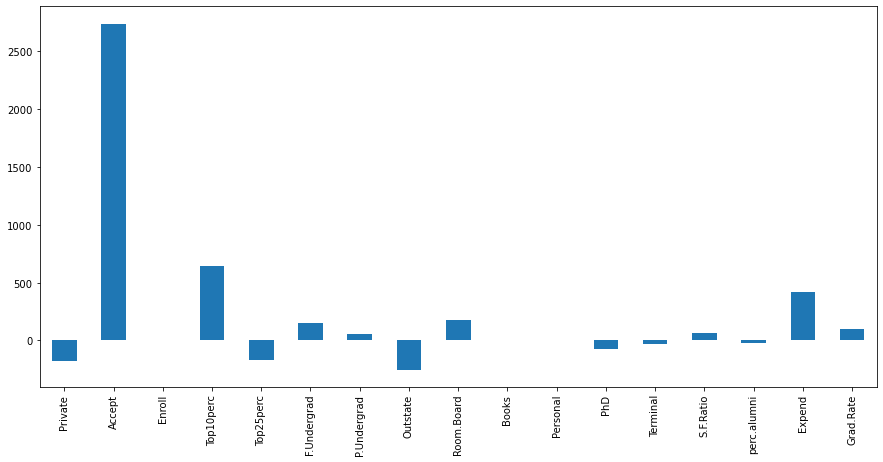

In [50]:
# plotting coefficients with corresponding features
pd.Series(lasso.coef_, index=features).plot.bar(figsize=(15, 7));

# Note some of the features (Enroll, Books, Personal) are completely zeroed out which is the advantage of using Lasso.
# It does feature selection for us

---
## Approach#2 - Model Prep: `PowerTransformer`
---
Apply a power transform, featurewise, to make data more Gaussian-like (Gaussian is another name for normal distribution). We saw from our features histogram that there are many features not normally distributed. ([sklearn documentation for PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html))

In Machine Learning, data satisfying Normal Distribution is beneficial for model building. It just makes math easier. Models like LDA, Gaussian Naive Bayes, Logistic Regression, Linear Regression, etc., are explicitly calculated from the assumption that the distribution is a bivariate or multivariate normal. ([Medium article explaining on the significance of Normal distribution in machine learning](https://medium.com/analytics-vidhya/normal-distribution-and-machine-learning-ec9d3ca05070))

This is an _alternate_ transformation vs standardization/scaling done previously.

Let's fit a `PowerTransformer` to `X_train` and use it to transform both `X_train` and `X_test`.

In [51]:
# repeating train-test split from original df's X, y
X_train_pwr, X_test_pwr, y_train_pwr, y_test_pwr = train_test_split(X, y, random_state=42)

In [52]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
X_train_pwr = pt.fit_transform(X_train_pwr)
X_test_pwr = pt.transform(X_test_pwr)

/Users/E057788/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


We also want to transform our target to resemble a normal distribution, so we'll create another `PowerTransformer` for our `y`.

In [53]:
pt_y = PowerTransformer()

# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
# while we didn't need to do this with X_train, which was already a dataframe
y_train_pt = pt_y.fit_transform(y_train_pwr.to_frame())
y_test_pt = pt_y.transform(y_test_pwr.to_frame())

In [54]:
# instantiating the same 3 models as before: linear regression, lassoCV and ridgeCV
lr_pwr = LinearRegression()
lasso_pwr = LassoCV(n_alphas=200)
ridge_pwr = RidgeCV(alphas=np.linspace(.1, 10, 100))

In [55]:
y_train_pt # logistic regression, ridgeCV cross validation can accept below list-of-list/vector format

array([[ 0.30222521],
       [-0.03514751],
       [-1.17858498],
       [-0.77145009],
       [-1.15039126],
       [-0.30465888],
       [ 1.47104039],
       [-0.27175463],
       [-1.10449513],
       [-0.61154421],
       [-0.15902687],
       [-0.20473197],
       [ 0.28523485],
       [-2.38148507],
       [-1.54968844],
       [-0.78296432],
       [ 1.42806224],
       [ 1.70629333],
       [-0.74744511],
       [ 1.38643253],
       [-1.04910698],
       [ 0.23309413],
       [-0.39972016],
       [-0.32640185],
       [-0.06815135],
       [ 1.15314826],
       [-0.10586695],
       [-0.46706955],
       [ 0.49735073],
       [-0.40931683],
       [ 1.58452524],
       [-0.26679763],
       [ 1.90116755],
       [-0.82593675],
       [-0.9334766 ],
       [ 1.50782412],
       [-0.81989066],
       [-0.90665401],
       [-0.21400506],
       [ 0.54214766],
       [-1.17419308],
       [ 0.67944813],
       [-0.72813122],
       [ 0.27594553],
       [ 2.18178981],
       [-1

In [56]:
y_train_pt[:, 0] #lassoCV requires y_train in a different unpacked list/1-D array format, else the next CV step throws error

array([ 0.30222521, -0.03514751, -1.17858498, -0.77145009, -1.15039126,
       -0.30465888,  1.47104039, -0.27175463, -1.10449513, -0.61154421,
       -0.15902687, -0.20473197,  0.28523485, -2.38148507, -1.54968844,
       -0.78296432,  1.42806224,  1.70629333, -0.74744511,  1.38643253,
       -1.04910698,  0.23309413, -0.39972016, -0.32640185, -0.06815135,
        1.15314826, -0.10586695, -0.46706955,  0.49735073, -0.40931683,
        1.58452524, -0.26679763,  1.90116755, -0.82593675, -0.9334766 ,
        1.50782412, -0.81989066, -0.90665401, -0.21400506,  0.54214766,
       -1.17419308,  0.67944813, -0.72813122,  0.27594553,  2.18178981,
       -1.8487885 , -1.24228064,  0.18997687,  1.2029544 ,  1.11646731,
        0.38011607, -1.70296749, -0.23284457,  0.53921209, -0.06223692,
       -0.76574591,  1.27690102,  0.69207305,  0.13576391,  0.94165089,
       -1.38934421,  0.51266031,  0.04029426,  2.13101817, -0.54425862,
       -0.53979511,  0.56495515,  0.41296319, -0.04601245,  2.01

In [57]:
# cross validating the above instantiated models
lr_pwr_scores = cross_val_score(lr_pwr, X_train_pwr, y_train_pt, cv=3)
print(f'lr_power: {lr_pwr_scores.mean()}')

lasso_pwr_scores = cross_val_score(lasso_pwr, X_train_pwr, y_train_pt[:, 0], cv=3)
print(f'lasso_power: {lasso_pwr_scores.mean()}')

ridge_pwr_scores = cross_val_score(ridge_pwr, X_train_pwr, y_train_pt, cv=3)
print(f'ridge_power: {ridge_pwr_scores.mean()}')

lr_power: 0.9611291261345908
lasso_power: 0.9609635869076224
ridge_power: 0.9610600772813348


The results are better than previously seen with `Standard Scaling`.

From the PowerTransformer cross validation scores above, `RidgeCV` seems to be doing the best, so let's move forward with that model to Fit the model to the training data, evaluate the training and test scores and predict on testing set below.

In [58]:
ridge_pwr.fit(X_train_pwr, y_train_pt)

RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ]))

In [59]:
ridge_pwr.score(X_train_pwr, y_train_pt)

0.9649105166148765

In [60]:
ridge_pwr.score(X_test_pwr, y_test_pt)

0.9678002418463295

In [61]:
y_pred_pwr = ridge_pwr.predict(X_test_pwr)

# before we compare y_true with y_pred for an r^2 score, we'll need to revert the PowerTransformer required y_format,
# with PowerTransformer_instance.inverse_transform
y_pred_pwr_reversed = pt_y.inverse_transform(y_pred_pwr)

In [62]:
r2_score(y_test, y_pred_pwr_reversed)

0.9445383916258507

Overall, the model is better performing compared to our 1st approach with `StandardScaler()`

As you can see, a lot of the code we write for training ML models are actually EDA and data manipulation.

The ML algorithms themselves can be trained with a few lines of code. 

According to some estimates [Link](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/?sh=60cd228f6f63), data cleaning and preparation takes up 60-80% of a data scientist's time. 

So make yourself super familiar with manipulating data in pandas. Many interview coding tests will test how well you can work with pandas dataframes!